### Data Ingestion

In [1]:
# How to read the data files in Python

import pandas as pd
users = pd.read_csv("https://s3.amazonaws.com/asana-data-interview/takehome_users-intern.csv")
user_engagement = pd.read_csv("https://s3.amazonaws.com/asana-data-interview/takehome_user_engagement-intern.csv")

# How to read the data files in R

#users <- read.csv("https://s3.amazonaws.com/asana-data-interview/takehome_users-intern.csv")
#user_engagement <- read.csv("https://s3.amazonaws.com/asana-data-interview/takehome_user_engagement-intern.csv")

### 1) Calculating Adoption Rate

In [2]:
users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,email_domain
0,1,4/22/14 3:53,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,yahoo.com
1,2,11/15/13 3:45,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,gustr.com
2,3,3/19/13 23:14,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0,gustr.com
3,4,5/21/13 8:09,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0,yahoo.com
4,5,1/17/13 10:14,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0,yahoo.com


In [3]:
user_engagement.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


We define adoption rate as User Adoption Rate = (adopted users / total users) * 100.

First we use the datatime module to convert the time_stamp column into datetime values, so we can count users through seven day increments.

Then, we can use group the dataset by the user IDs and apply rolling counts to find the users and number of users who are adopted users. 

In [4]:
#This is a variable that shows the total number of users who visited the product. This will be useful as our denominator when calculating adoption rate.
totalUsers = len(user_engagement['time_stamp'].unique())
totalUsers

207220

We will now convert the time stamp column into date time values. This will make it easier to subtract days, allowing us to creating the rolling averages per seven days. 

In [5]:
from datetime import datetime
userTimes = []
for time in user_engagement['time_stamp']:
  userTimes.append(datetime.strptime(time, '%Y-%m-%d %H:%M:%S'))


In [6]:
user_engagement['time_stamp'] = userTimes
user_engagement = user_engagement.sort_values(['time_stamp'])
user_engagement.head()

,time_stamp,user_id,visited
178140,2012-05-31 08:20:06,10012,1
59486,2012-05-31 15:47:36,3428,1
175638,2012-05-31 17:19:37,9899,1
26821,2012-05-31 21:58:33,1693,1
109716,2012-06-01 00:17:30,6102,1


In [7]:
#Function to find the user ids that appear three or more times in a list that represents a seven day span.
#We can use this as a back up to check if our rolling count (below) is correct. 
from collections import Counter
 
def threePeatUsers(arr):
    n = len(arr)
    result = []
    freq = Counter(arr)
    for i in freq:
        if(freq[i] > 2):
            result.append(i)
    return result


In [8]:
usersInSeven = user_engagement.set_index("time_stamp").groupby("user_id").rolling("7D").count()
usersInSeven.columns=["users_in_prev_7_days"]
usersInSeven = usersInSeven.reset_index()
adoptedUsers = len(usersInSeven[usersInSeven['users_in_prev_7_days'] >= 3])
adoptedUsers 

160522

In [9]:
print("The adoption rate is " + str( (adoptedUsers / totalUsers) * 100) + "%.")

The adoption rate is 77.4645304507287%.


### 2) Methodology

We want to see which factors out the users dataset are most related to being an adopted user. Hence, we will append an indicator column to the users dataset to signify which users are adopted and a count column to show a user's number of visits in a rolling seven day span. 

In [10]:
users['is_adopted'] = 0

In [11]:
#This for loop goes through the user dataset and checks if the users are in the list of adopted users
for i in range(len(users)): 
  if users.iloc[i][0] in list(usersInSeven[usersInSeven['users_in_prev_7_days'] > 2]['user_id'].unique()):
    users['is_adopted'][i] = 1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [12]:
users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,email_domain,is_adopted
0,1,4/22/14 3:53,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,yahoo.com,0
1,2,11/15/13 3:45,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,gustr.com,1
2,3,3/19/13 23:14,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0,gustr.com,0
3,4,5/21/13 8:09,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0,yahoo.com,0
4,5,1/17/13 10:14,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0,yahoo.com,0


In [13]:
#To test:
users[users['object_id'] == 10]

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,email_domain,is_adopted
9,10,1/16/13 22:08,Santos Carla,CarlaFerreiraSantos@gustr.com,ORG_INVITE,1.401833e+09,1,1,318,4143.0,gustr.com,1


We want to see if we should consider email domain 

In [14]:
users['email_domain'].value_counts().tail()

lrabg.com    1
mrytw.com    1
ugtav.com    1
hqhll.com    1
iuxiw.com    1
Name: email_domain, dtype: int64

Since there are several email domains that are either extremely uncommon or seemingly facetious, we will refrain from using one hot encoding for email domains, along with name.

Next, we want to consider creation source as a factor. Unlike email domains, this column has relevant information and can be converted into numerical information via one hot encoding. 

In [27]:
#We also want to consider the factors that are denoted by string values. For that, we will use one hot encoding
users2 = pd.get_dummies(users, columns=['creation_source'])
users2.head()

,object_id,creation_time,name,email,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,email_domain,is_adopted,creation_source_GUEST_INVITE,creation_source_ORG_INVITE,creation_source_PERSONAL_PROJECTS,creation_source_SIGNUP,creation_source_SIGNUP_GOOGLE_AUTH
0,1,4/22/14 3:53,Clausen August,AugustCClausen@yahoo.com,1.398139e+09,1,0,11,10803.0,yahoo.com,0,1,0,0,0,0
1,2,11/15/13 3:45,Poole Matthew,MatthewPoole@gustr.com,1.396238e+09,0,0,1,316.0,gustr.com,1,0,1,0,0,0
2,3,3/19/13 23:14,Bottrill Mitchell,MitchellBottrill@gustr.com,1.363735e+09,0,0,94,1525.0,gustr.com,0,0,1,0,0,0
3,4,5/21/13 8:09,Clausen Nicklas,NicklasSClausen@yahoo.com,1.369210e+09,0,0,1,5151.0,yahoo.com,0,1,0,0,0,0
4,5,1/17/13 10:14,Raw Grace,GraceRaw@yahoo.com,1.358850e+09,0,0,193,5240.0,yahoo.com,0,1,0,0,0,0


We will now create a correlation matrx to visualize the relationships between different factors and the adoption indicator column. 

In [17]:
correlationMatrix = users2.corr()
users2['is_adopted'].sort_values(ascending = False)

users2['last_session_creation_time'].fillna(0, inplace = True)
users2['is_adopted'].fillna(0, inplace = True)

correlationMatrix['is_adopted']

object_id                             0.005750
last_session_creation_time            0.396550
opted_in_to_mailing_list              0.008097
enabled_for_marketing_drip            0.004653
org_id                                0.064523
invited_by_user_id                    0.000675
is_adopted                            1.000000
creation_source_GUEST_INVITE          0.045408
creation_source_ORG_INVITE           -0.007636
creation_source_PERSONAL_PROJECTS    -0.075817
creation_source_SIGNUP                0.009299
creation_source_SIGNUP_GOOGLE_AUTH    0.036119
Name: is_adopted, dtype: float64

Evidently, the most correlated factors are last session creation time, organization ID, and certain types of creation source. 

The visualization for the matrix is below. 

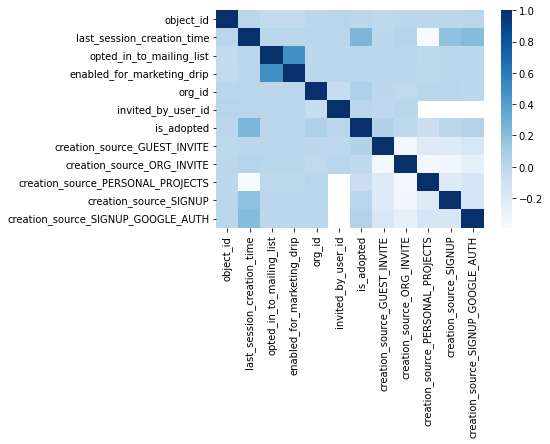

In [18]:
import seaborn as sns
sns.heatmap(users2.corr(), cmap = "Blues")


##### 2a) Writeup associated with methodology

### 3) What Factors Predict User Adoption?

We drop all factors that have low correlation or little relevance to whether a user is adopted. 
We want to avoid the following factors:
 - object_id
 - enabled_for_marketing_drip
 - invited_by_user_id
 - creation_time
 - name
 - email
 - email_domain
The name, email, email_domain, object_id, and creation_time should not be included because all of those values are essentially unique to the user and hence have little relevance to what we want to predict. We want to drop enabled_for_marketing_drip and invited_by_user_id because those factors have little correlation to the result.

In [28]:
users3 = users2[['last_session_creation_time', 'opted_in_to_mailing_list', 'org_id', 'creation_source_GUEST_INVITE', 'creation_source_ORG_INVITE',	
                 'creation_source_PERSONAL_PROJECTS',	'creation_source_SIGNUP',	'creation_source_SIGNUP_GOOGLE_AUTH', 'is_adopted']]
users3.head()

,last_session_creation_time,opted_in_to_mailing_list,org_id,creation_source_GUEST_INVITE,creation_source_ORG_INVITE,creation_source_PERSONAL_PROJECTS,creation_source_SIGNUP,creation_source_SIGNUP_GOOGLE_AUTH,is_adopted
0,1.398139e+09,1,11,1,0,0,0,0,0
1,1.396238e+09,0,1,0,1,0,0,0,1
2,1.363735e+09,0,94,0,1,0,0,0,0
3,1.369210e+09,0,1,1,0,0,0,0,0
4,1.358850e+09,0,193,1,0,0,0,0,0


We can use a Random Forest Classifier to predict adoption depending on the relevant factors

In [20]:
x = users3[users3 != 'is_adopted']
y = users3['is_adopted']

In [21]:
#We split the data into train and test datasets

from sklearn.metrics import accuracy_score, roc_auc_score, make_scorer
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier

x_train, x_test, y_train, y_test = train_test_split(x,y,test_size = 0.3,random_state=3)

In [22]:
x_train = x_train[['last_session_creation_time',	'opted_in_to_mailing_list',	'org_id',	'creation_source_GUEST_INVITE',	'creation_source_ORG_INVITE',	'creation_source_PERSONAL_PROJECTS',	'creation_source_SIGNUP',	'creation_source_SIGNUP_GOOGLE_AUTH']]
x_test = x_test[['last_session_creation_time',	'opted_in_to_mailing_list',	'org_id',	'creation_source_GUEST_INVITE',	'creation_source_ORG_INVITE',	'creation_source_PERSONAL_PROJECTS',	'creation_source_SIGNUP',	'creation_source_SIGNUP_GOOGLE_AUTH']]

For the Random Forest Classifier, we want to tune the hyperparameters to ensure the model fits that data the best. 

In [23]:
#Hyperparameter tuning

# Possible Hyperparameters
# number of trees
n_estimators = [10, 20, 40, 60, 100, 200]
# max number of levels in tree
max_depth = [10, 20, 30, 40, 50]
max_features = ['auto', 'sqrt']
# minimum number of samples required to split a node
min_samples_split = [2,5,10, 15, 20]
# minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 5, 10, 15]
bootstrap = [True, False]

param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

rfc = RandomForestClassifier(random_state = 1)
rfc_rscv = RandomizedSearchCV(estimator = rfc, param_distributions = param_grid, n_iter = 10, cv = 5, verbose = 2, random_state = 42, n_jobs = -1)

rfc_rscv.fit(x_train, y_train)

print(rfc_rscv.best_params_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
{'n_estimators': 10, 'min_samples_split': 15, 'min_samples_leaf': 15, 'max_features': 'auto', 'max_depth': 10, 'bootstrap': False}


In [24]:
#We fit the model. 
import matplotlib.pyplot as plt
import numpy as np

rfc = RandomForestClassifier(n_estimators = 10, random_state = 1, criterion = 'gini', class_weight = 'balanced', 
                             min_samples_split = 15, min_samples_leaf = 15, max_features = 'auto', max_depth = 10, bootstrap = False)

rfc.fit(x_train, y_train)

RandomForestClassifier(bootstrap=False, class_weight='balanced', max_depth=10,
                       min_samples_leaf=15, min_samples_split=15,
                       n_estimators=10, random_state=1)

Finally, we can extract the features and their associated importance.
We display a Pandas data frame showing the factors and importance, along with a horizontal bar plot. 

In [25]:
featureImps = pd.DataFrame({'Features' : x_train.columns, 'Importance' : rfc.feature_importances_})
featureImps = featureImps.sort_values(by = ['Importance'], ascending = False)
featureImps

,Features,Importance
0,last_session_creation_time,0.910481
2,org_id,0.063074
5,creation_source_PERSONAL_PROJECTS,0.012978
3,creation_source_GUEST_INVITE,0.004005
1,opted_in_to_mailing_list,0.003139
6,creation_source_SIGNUP,0.002542
4,creation_source_ORG_INVITE,0.002176
7,creation_source_SIGNUP_GOOGLE_AUTH,0.001605


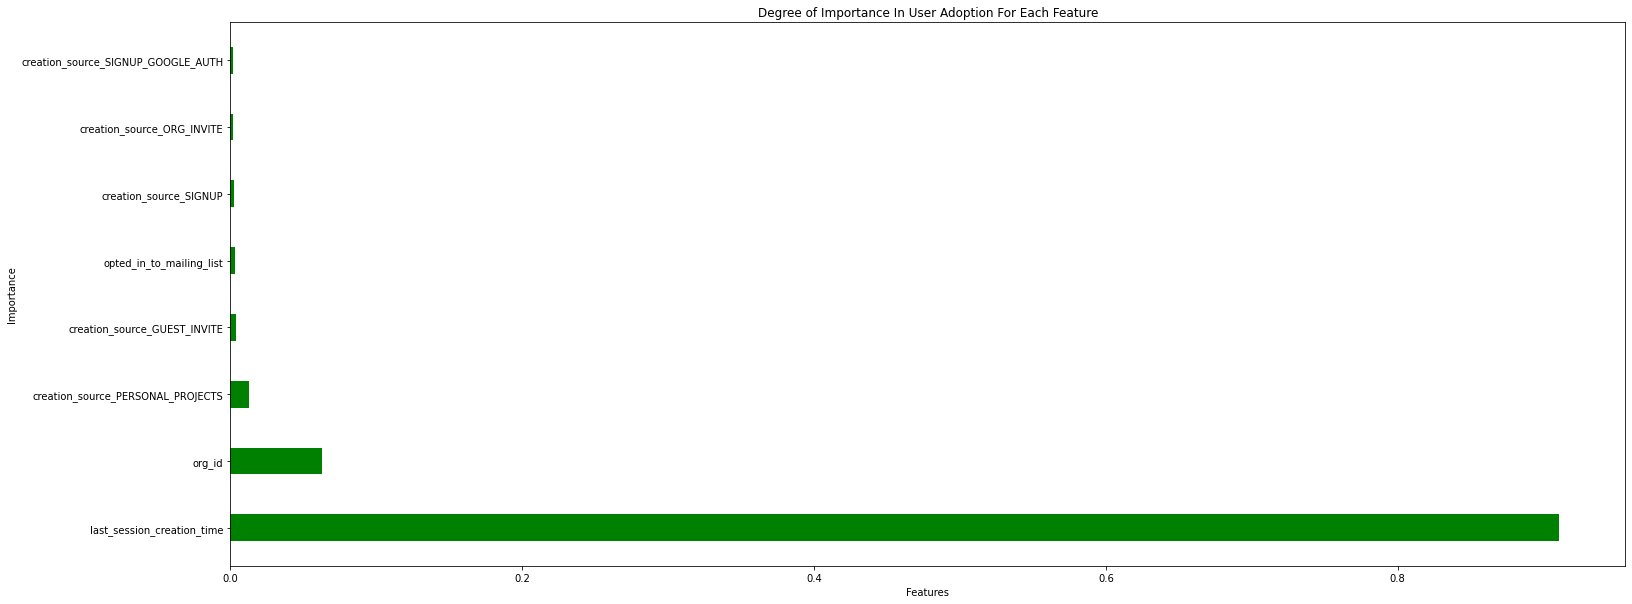

In [26]:
fig = plt.figure(figsize = (25, 10))
plt.barh(y = featureImps['Features'], width = featureImps['Importance'], height = .4, color = "green")
plt.xlabel("Features")
plt.ylabel("Importance")
plt.title("Degree of Importance In User Adoption For Each Feature")
plt.show()

Thus, we see that last session creation time, organization ID, creation source by personal projects, and creation source by guest invites are the most important factors that lead to user adoption.  